# House Prices
## Advanced Regression Techniques
### Predict sales prices and practice feature engineering, RFs, and gradient boosting

The Housing Prices competition is a _Getting Started Prediction Competion_ on the Kaggle website. The data for the competition comes from the Ames Housing dataset created by Dean De Cock. 

As per Kaggle: 


> _Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence._

> _With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home._

See [The competition page](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview) for more information. 




# Notebook Overview

This notebook takes a "quick and dirty" approach to building a baseline model. It starts with brief exploratory data analysis to check for null values and outliers. It then quickly moves on to model building, testing, and hyperparameter tuning with H2O's AutoML package. It finishes with a comparison of model performance metrics.

Key takeaways: 
1. How to use the Kaggle API
2. Baseline model building and tuning with AutoML
3. Root Mean Square Error (RMSE) vs. Root Mean Squared Logarithmic Error (RMSLE) as model performance metrics


# Part I: Import Data

In this section, the data is imported into the notebook using the Colab drive library and the Kaggle API. 

A unique `kaggle.json` is created at the Kaggle user profile page. The file is placed in Google Drive for easy access via Colab's `drive.mount()` function.

The Kaggle package is installed via `pip`. The json file is copied into the local folder, a kaggle directory is created, and the read/write access permission is granted to the file via the command line. Finally, the competition data is downloaded via the Kaggle API and the files are unzipped into a local directory.

#### References:
[1](https://www.kaggle.com/general/74235) _Easiest way to download kaggle data in Google Colab_ by [Filemon](https://www.kaggle.com/harshthaker) </br>
[2](https://github.com/Kaggle/kaggle-api) _Kaggle API GitHub repo_ </br>
[3](https://stackoverflow.com/questions/55761202/is-there-any-alternative-way-to-download-kaggle-competition-data-in-colab) _Is there any alternative way to download kaggle competition data in Colab?_ answer by [kayo](https://stackoverflow.com/users/6712832/kayo) 

In [ ]:
# import drive library and mount Drive for local access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# pip install kaggle api
!pip install -q kaggle

In [ ]:
# Copy kaggle.json to .kaggle folder and grant read/write access
!mkdir ~/.kaggle
!cp '/content/drive/MyDrive/Data Analysis/kaggle.json' ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset via the Kaggle commandline API
!kaggle competitions download -c house-prices-advanced-regression-techniques

100% 199k/199k [00:00<00:00, 538kB/s]
100% 199k/199k [00:00<00:00, 537kB/s]


In [ ]:
# Create directory for the files and place the unziped files inside
!mkdir data
!unzip /content/house-prices-advanced-regression-techniques.zip -d data

Archive:  /content/house-prices-advanced-regression-techniques.zip
  inflating: data/data_description.txt  
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


# Part II: Quick and Dirty EDA

This section is a quick exploratory data analysis. The primary concern is to get a feel for the data and look for egregious problems, like missing values, skewed data, or outliers. These problems, where present, are not addressed. They are simply noted for later. The primary concern is to start modeling.



## Data Import & Overview

Below packages for visualization and analysis are imported and the data is read. This will provide the first look at the dataset. 

In [ ]:
# Import packages for analysis and create Pandas train and test dataframes
# import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# warnings.filterwarnings("ignore")
# warnings.simplefilter('once', RuntimeWarning)

pd_train = pd.read_csv("data/train.csv")
pd_test = pd.read_csv("data/test.csv")
pd_train.shape

(1460, 81)

In [ ]:
# Show train data
pd_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
# Show overview of values and data types
pd_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Feature Data Visualization & Summary Statistics

This section presents a visual overview and basic summary statistics for the data. This analysis provides three key takeaways:

1. Many of the features are right-skewed
2. The features contain outliers
3. The data contains a large number of zero and missing values

#### Right-skew

The histogram subplots for the feature columns are right-skewed. LotFrontage, LotArea, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, GrLivArea, GarageArea, and OpenPorchSF are all examples. YearBuilt and GrageYrBlt are notable exceptions. These features have a pronounced left-skew. This means that some values are over represented in the data set. The houses in the data set tend to have a smaller lot frontage, lot area, first-floor square footage, etc., but are built more recently with newer garages. 

#### Outliers

The box plots show that the majority of features contain outliers. LotFrontage and TotalBsmetSF are two examples. The average lot frontage is approximately 65 feet, however one, solo observation is over 310 feet. Likewise, the average total basement square footage is approximately 1000 sq. ft., however there is one record with a basement area of over 6000 sq. ft. These extreme values have the potential to throw off the predictive models, especially linear regression based models, which are sensitive to extreme values. 

#### Null & Zero Values

The last observation of note is the number of null values and zeros in the dataset. The heat maps below show the missing values for each feature. Existing values are shown in yellow and zero/null values are shown in blue. The plot of the zero values indicate that they are less of an issue. It makes logical sense that the value for houses without exterior second floor space or no pool would be zero. 

The NaN values in the data are more of an issue. It's hard to know what they mean. The NaN values for LotFrontage is an example. NaN is not an unreasonable value for lot frontage. It could be that these missing observations are for living spaces, like apartments, that do not include yards and/or do not face the street and, therefore, they have no lot of frontage. However, this is a potentially dangerous assumption. It would be better to record them as zero at the time the records were compiled, however, because this was not done, it can be problematic to assume that the values are zero rather than simply missing or mislabeled.

The null values are an issue that will need to be addressed in the modeling stage because many machine learning libraries can not handle missing values.

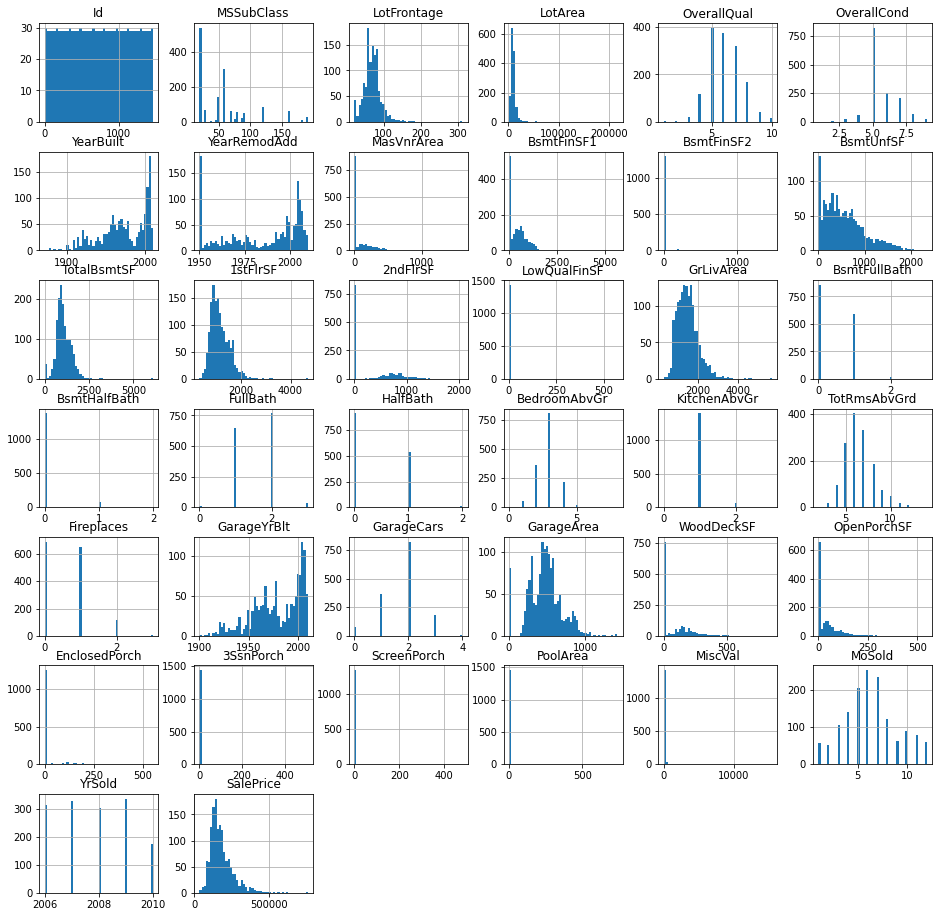

In [ ]:
# Histograms of all columns
pd_train.hist(bins=50, figsize=(16,16))
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seab

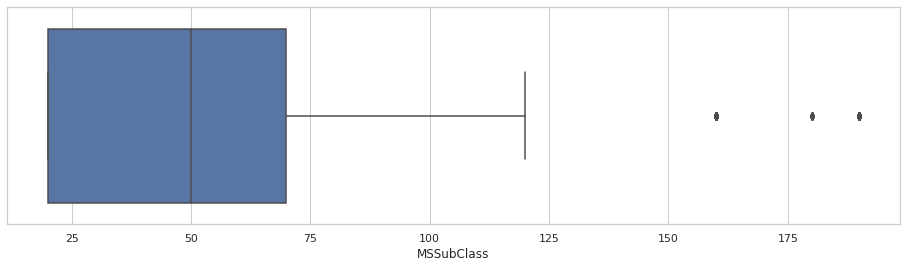

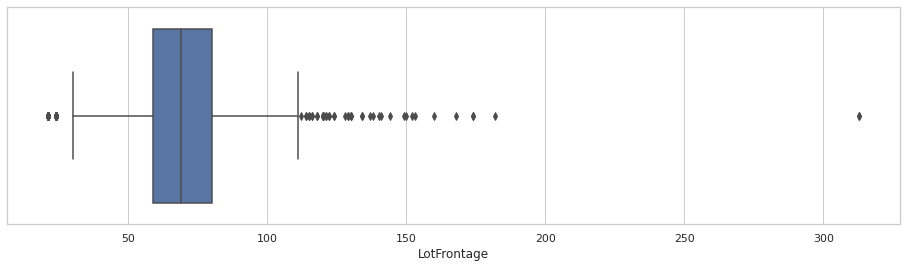

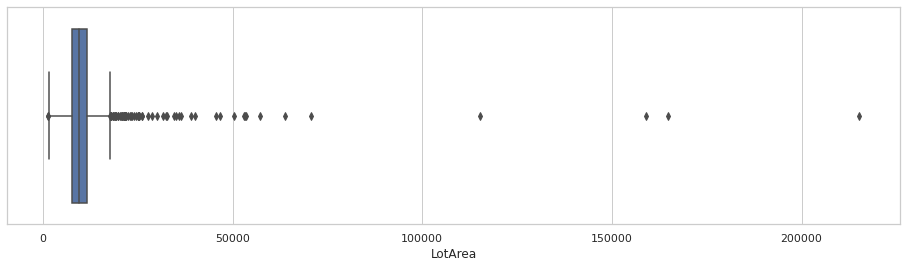

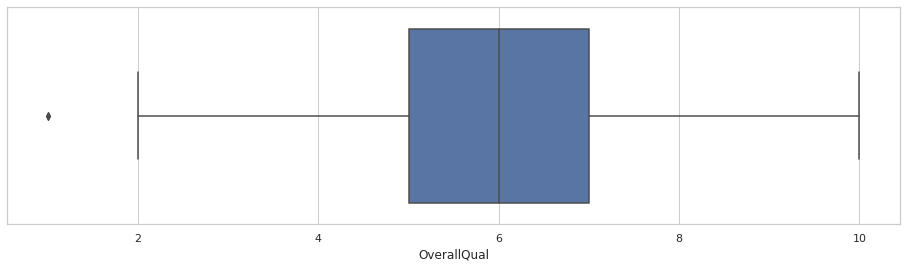

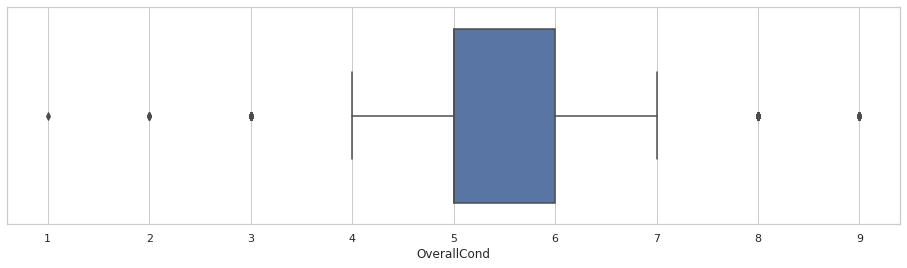

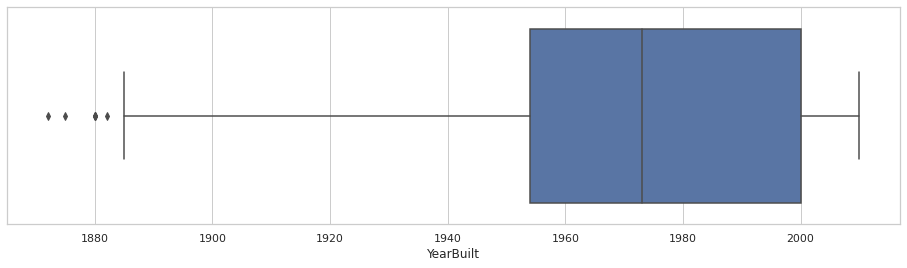

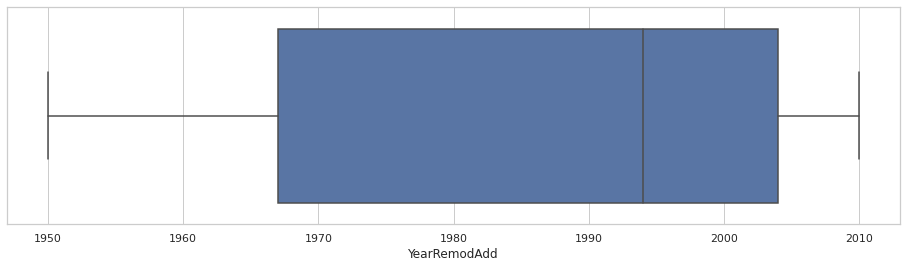

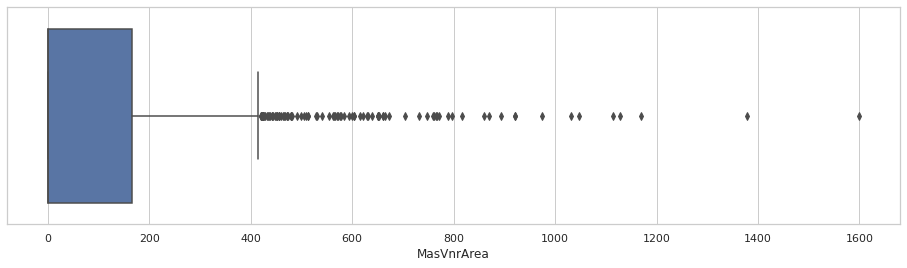

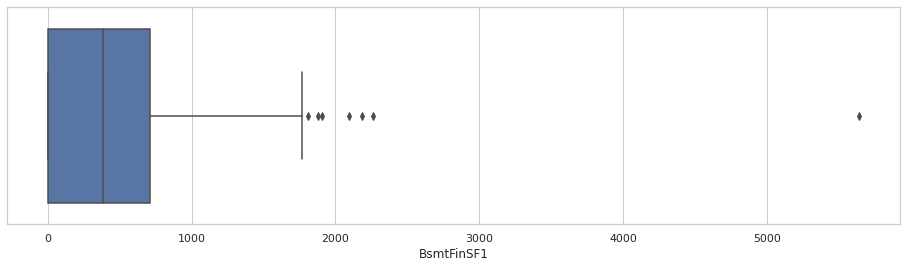

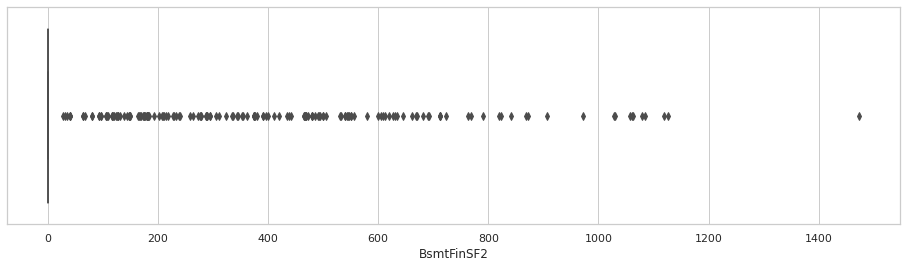

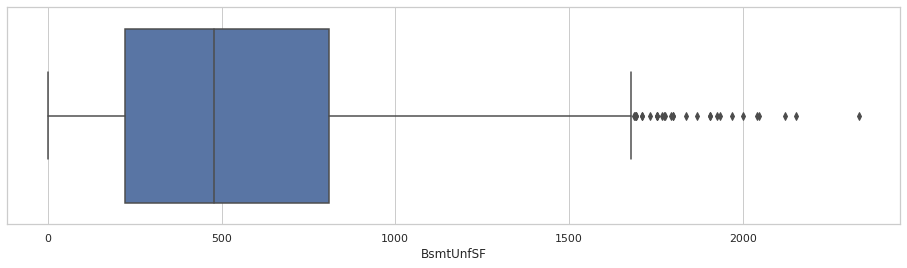

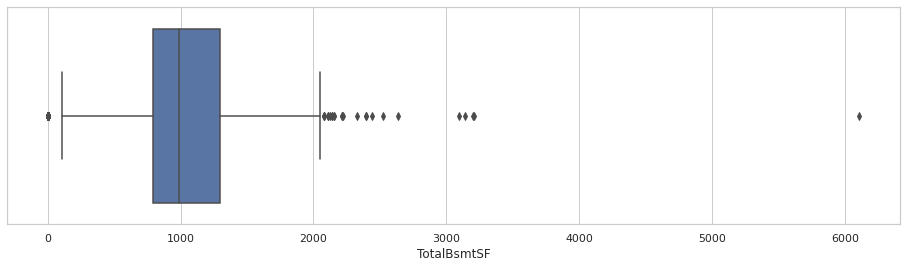

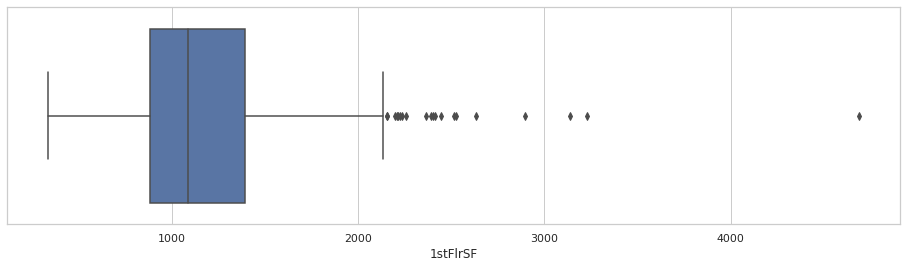

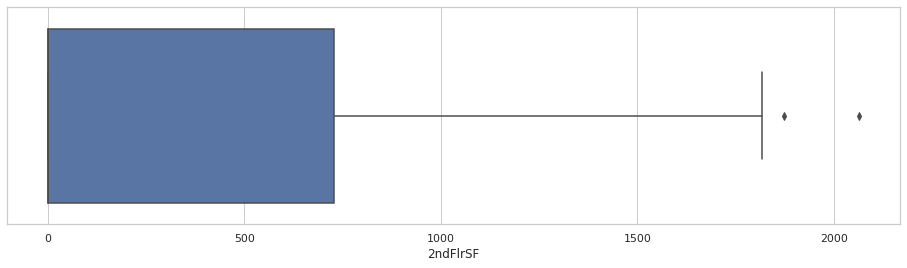

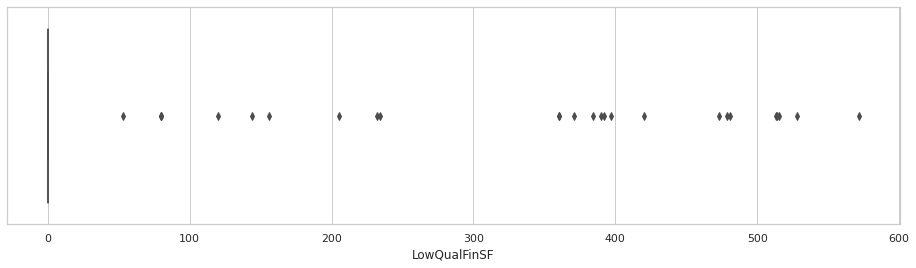

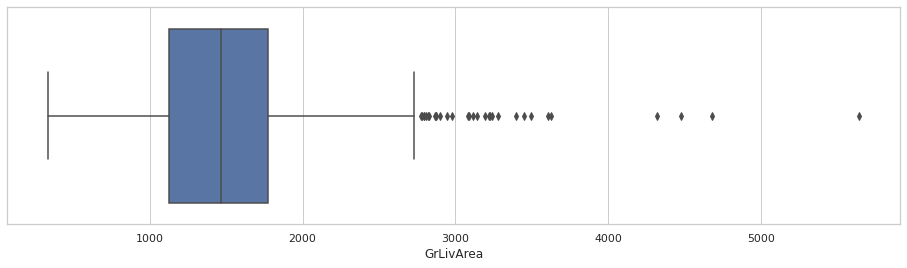

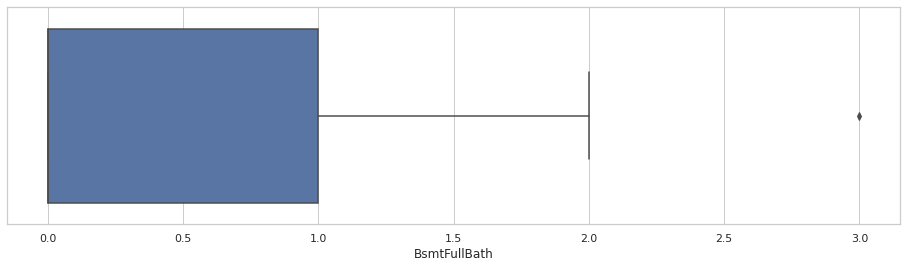

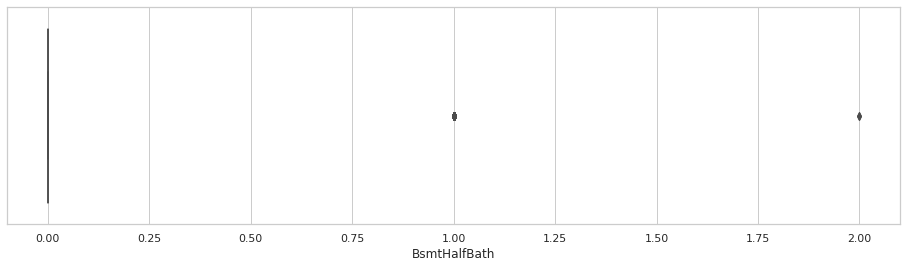

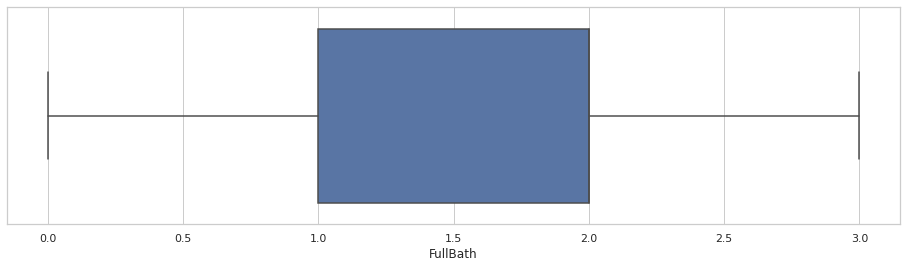

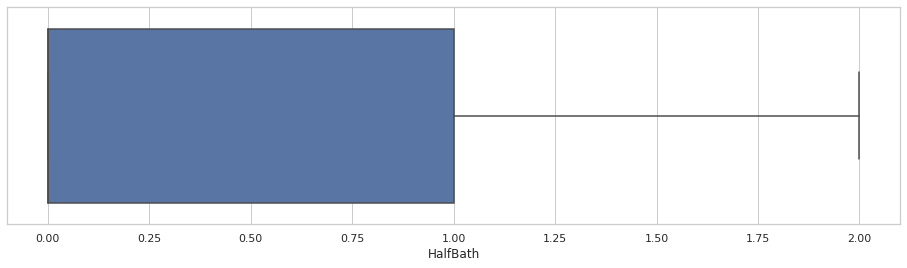

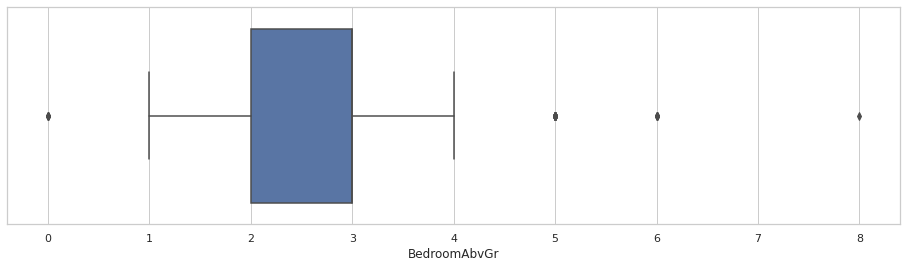

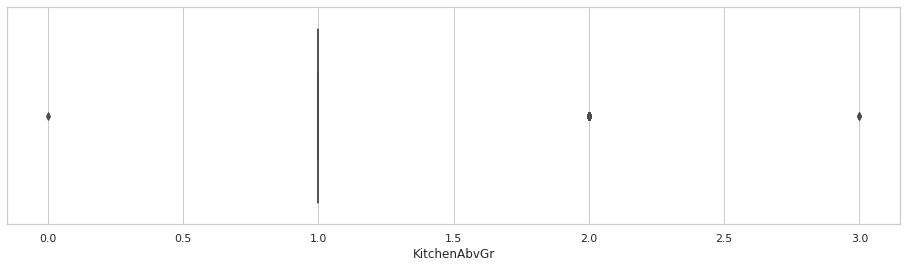

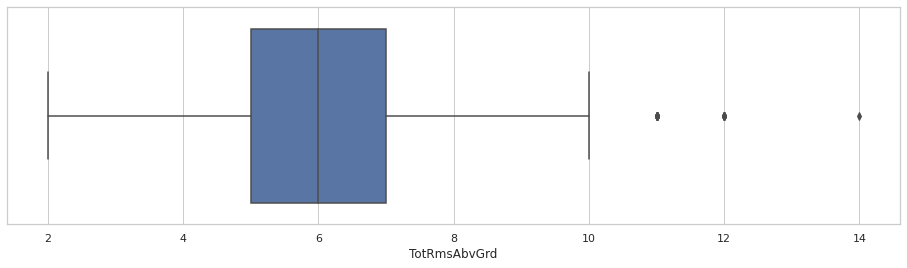

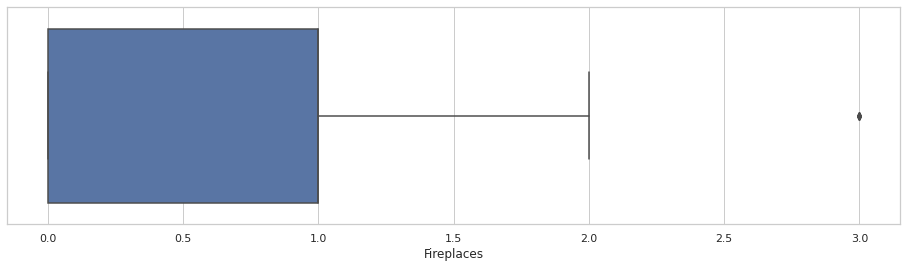

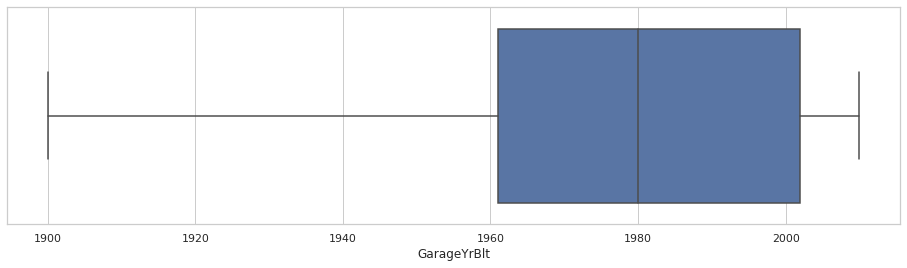

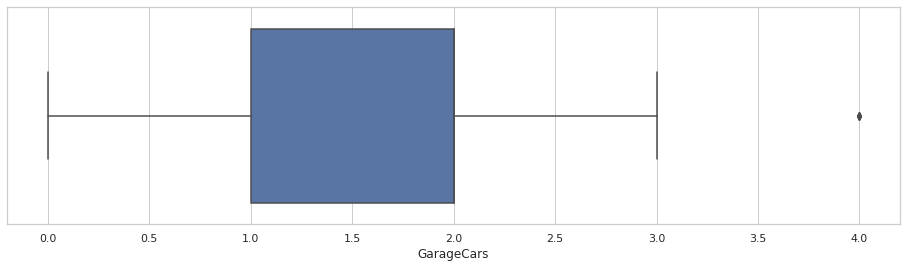

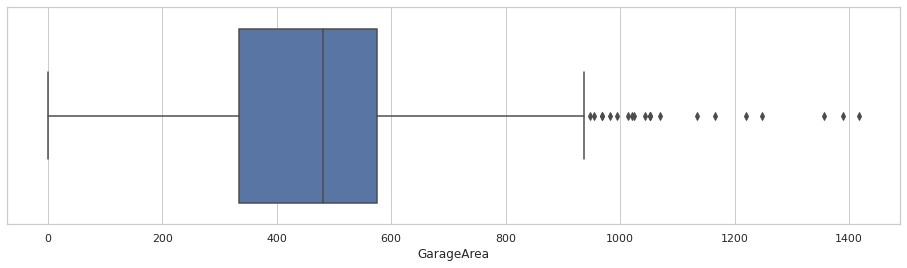

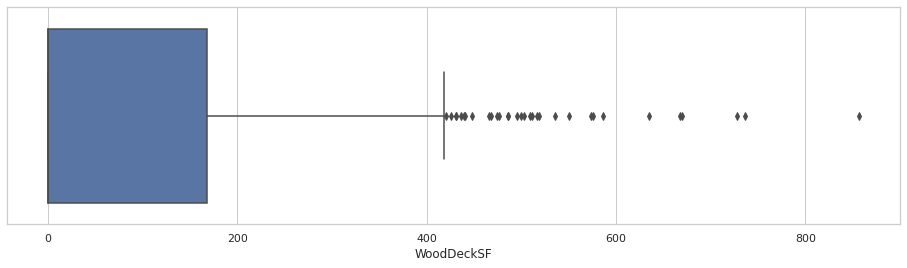

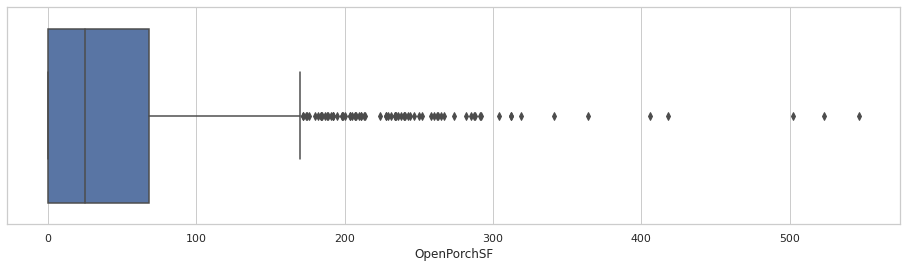

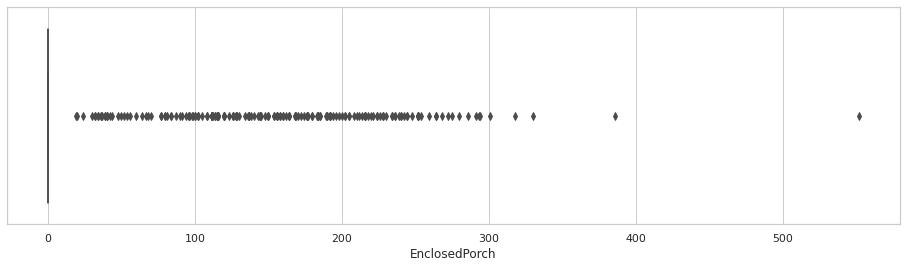

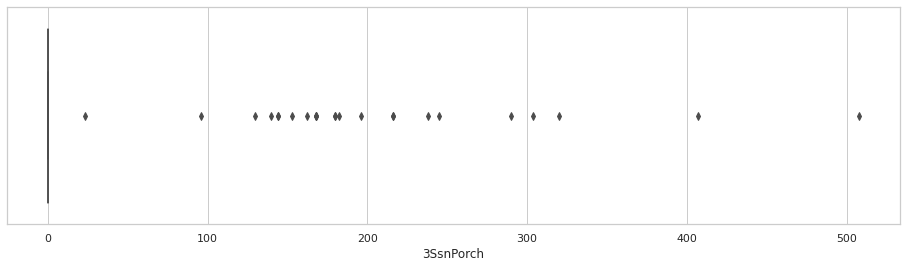

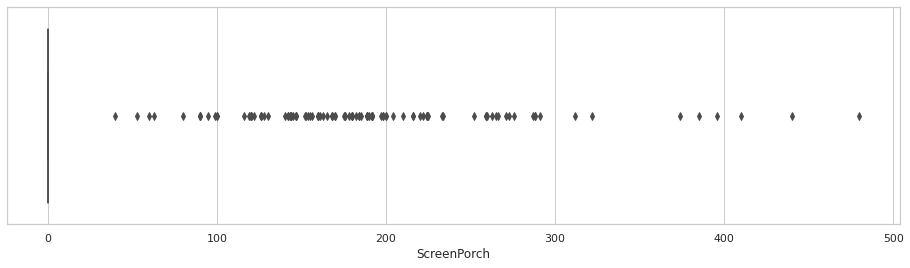

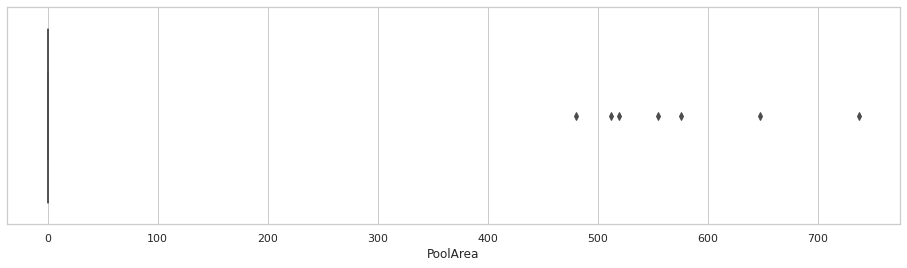

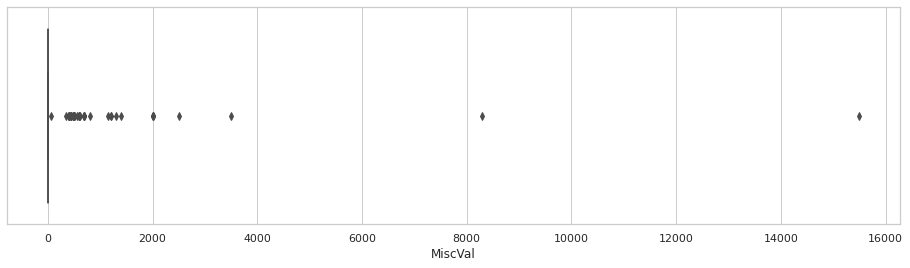

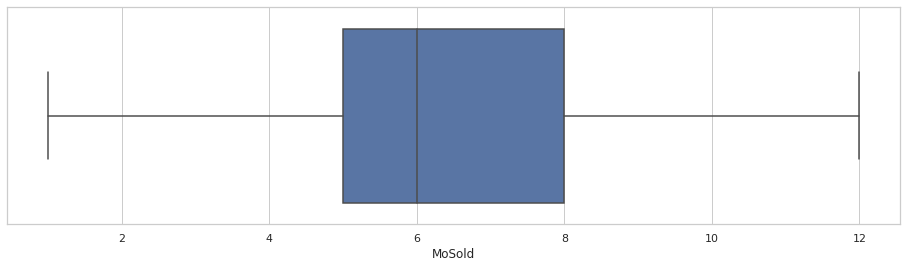

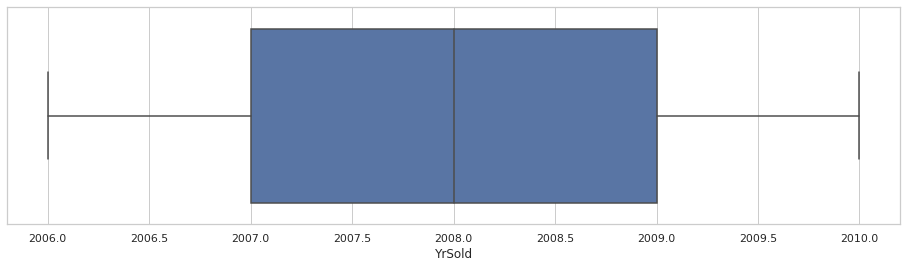

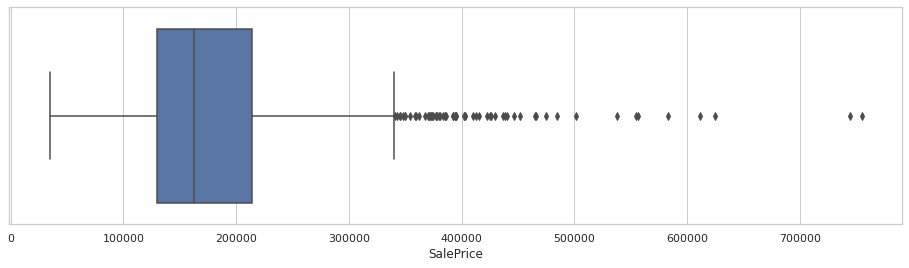

In [ ]:
# Bar plots for each category. There are outliers for many features.

numerical_df = pd_train.select_dtypes(exclude=['object'])
numerical_df = numerical_df.drop(["Id"], axis=1)
for column in numerical_df:
    plt.figure(figsize=(16, 4))
    sns.set_theme(style="whitegrid")
    sns.boxplot(numerical_df[column])

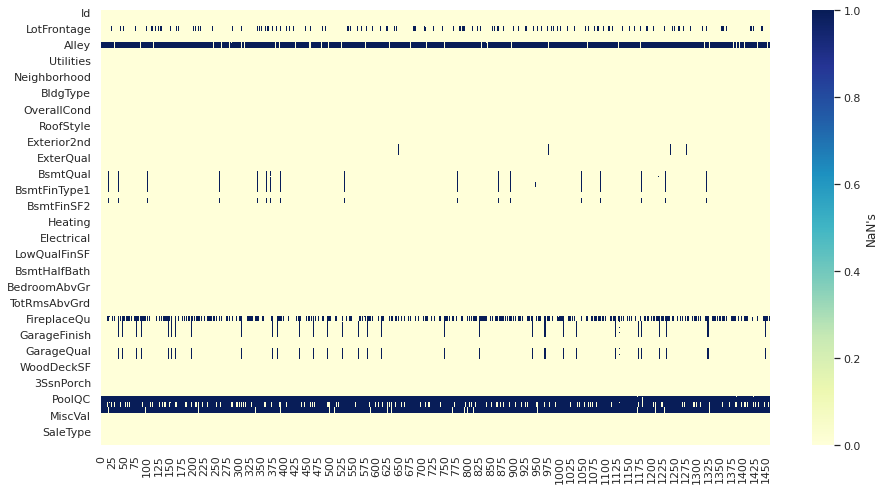

In [ ]:
# Heatmap of missng values in the dataset. NaN values are in dark blue.
plt.figure(figsize = (15,8))
sns.heatmap(pd_train.isin([np.nan]).transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': "NaN's"})

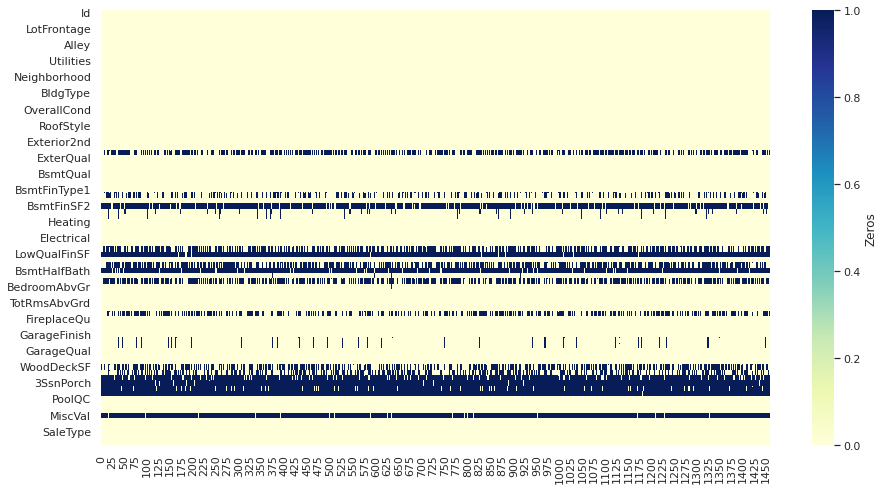

In [ ]:
# Heatmap of zero values in the dataset. NaN values are in dark blue.

plt.figure(figsize = (15,8))
sns.heatmap(pd_train.isin([0]).transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': "Zeros"})

## Dependent Variable Overview

The dependent variable is sale price. The distribution plot below shows that sales price, like many of the independent variables, is right-skewed. There is at least one outlier, which is more than five times the mean sales price. The mode value is \$140,000, the median value is \$163,000, and the mean value is \$180,921. The significant difference between the mode and mean value is an indication of the outsized effect of the extreme  sale price outlier value. Again, this is not something that will be addressed in the initial modeling. However, it is something to note for later.  

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


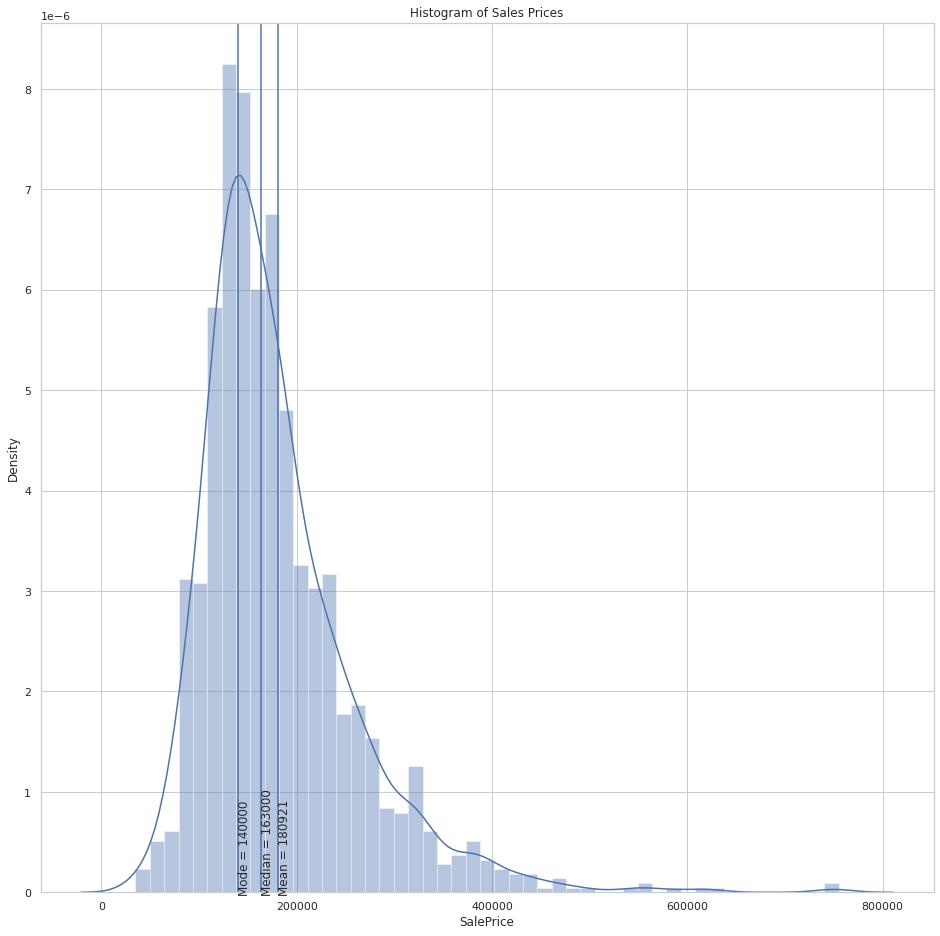

In [ ]:
# Distribution plot of dependent varable, SalePrice. Vertical lines for 
# mode, mean, and median values are included. 

stats = [('Mode', pd_train['SalePrice'].mode()[0]), ('Mean', pd_train['SalePrice'].mean()), ('Median',pd_train['SalePrice'].median())]

f, ax = plt.subplots(figsize=(16, 16))
sns.distplot(pd_train["SalePrice"], kde=True)
for stat in stats:
    plt.axvline(x=stat[1])
    plt.text(stat[1] + .2, 0, f"{stat[0]} = {stat[1]:.0f}", rotation=90)
plt.title("Histogram of Sales Prices")
plt.show()

# Part II: Modeling with AutoML

AutoML is an automated model building and hyperparameter tuning package by H2O.ai. It has a number of advantages over other popular machine learning libraries like Scikit-learn and XGBoost. The key advantages are:

1. Automatic encoding for null values
2. Automatic one-hot encoding for categorical variables
3. Highly optimized Java backend for lightening fast calculations

These make it a good choice for quick-and-dirty baseline model building because it handles the time consuming manual work of imputing missing values and encoding categorical variables.

## AutoML Instillation

AutoML requires a number of unique installation steps compared to classic machine learning libraries. Java Runtime Environment must be installed. The H2O library must be loaded and the H2O instance needs to be initialized.

#### Reference:
[1](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html#h2oframe) H2O Documentation, Data Manipulation, H2OFrame

In [ ]:
# Install Java for H20 library
!apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
openjdk version "11.0.17" 2022-10-18
OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)


In [ ]:
# Pip install h2o library in quiet mode
!pip install -q h2o

     |████████████████████████████████| 177.5 MB 43 kB/s 


In [ ]:
# Import H2O and initialize
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.8/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpm9bmq5gj
  JVM stdout: /tmp/tmpm9bmq5gj/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpm9bmq5gj/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_unknownUser_733bg3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


## Load Data & Data

H2O and the AutoML library require that the data be loaded into an H2OFrame. In this section, the data is loaded from local csv files. The 'Id' column is dropped because it is a unique record identifier and will not help modeling. 

In [ ]:
# Load data into H2OFrames
data = h2o.import_file("data/train.csv")
valid = h2o.import_file("data/test.csv")
data

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,12,2008,WD,Normal,250000
6,50,RL,85,14115,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NA,Attchd,1993,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000
7,20,RL,75,10084,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NA,NA,NA,0,8,2007,WD,Normal,307000
8,60,RL,nan,10382,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NA,NA,Shed,350,11,2009,WD,Normal,200000
9,50,RM,51,6120,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NA,NA,NA,0,4,2008,WD,Abnorml,129900
10,190,RL,50,7420,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,Y,SBrkr,1077,0,0,1077,1,0,1,0,2,2,TA,5,Typ,2,TA,Attchd,1939,RFn,1,205,Gd,TA,Y,0,4,0,0,0,0,NA,NA,NA,0,1,2008,

In [ ]:
# Drop Id column and view
data = data.drop(0)
valid = valid.drop(0)
data

MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,2,2008,WD,Normal,208500
20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,5,2007,WD,Normal,181500
60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,9,2008,WD,Normal,223500
70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,12,2008,WD,Normal,250000
50,RL,85,14115,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NA,Attchd,1993,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000
20,RL,75,10084,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NA,NA,NA,0,8,2007,WD,Normal,307000
60,RL,nan,10382,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NA,NA,Shed,350,11,2009,WD,Normal,200000
50,RM,51,6120,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NA,NA,NA,0,4,2008,WD,Abnorml,129900
190,RL,50,7420,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,Y,SBrkr,1077,0,0,1077,1,0,1,0,2,2,TA,5,Typ,2,TA,Attchd,1939,RFn,1,205,Gd,TA,Y,0,4,0,0,0,0,NA,NA,NA,0,1,2008,WD,Normal,118000


In [ ]:
# View validation data. This dataset does not include the response variable, sales price.
# This dataset will be used to make predictions and score the model via the Kaggle API

valid

MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
20,RH,80,11622,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,CBlock,TA,TA,No,Rec,468,LwQ,144,270,882,GasA,TA,Y,SBrkr,896,0,0,896,0,0,1,0,2,1,TA,5,Typ,0,NA,Attchd,1961,Unf,1,730,TA,TA,Y,140,0,0,0,120,0,NA,MnPrv,NA,0,6,2010,WD,Normal
20,RL,81,14267,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108,TA,TA,CBlock,TA,TA,No,ALQ,923,Unf,0,406,1329,GasA,TA,Y,SBrkr,1329,0,0,1329,0,0,1,1,3,1,Gd,6,Typ,0,NA,Attchd,1958,Unf,1,312,TA,TA,Y,393,36,0,0,0,0,NA,NA,Gar2,12500,6,2010,WD,Normal
60,RL,74,13830,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,PConc,Gd,TA,No,GLQ,791,Unf,0,137,928,GasA,Gd,Y,SBrkr,928,701,0,1629,0,0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997,Fin,2,482,TA,TA,Y,212,34,0,0,0,0,NA,MnPrv,NA,0,3,2010,WD,Normal
60,RL,78,9978,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20,TA,TA,PConc,TA,TA,No,GLQ,602,Unf,0,324,926,GasA,Ex,Y,SBrkr,926,678,0,1604,0,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998,Fin,2,470,TA,TA,Y,360,36,0,0,0,0,NA,NA,NA,0,6,2010,WD,Normal
120,RL,43,5005,Pave,NA,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0,Gd,TA,PConc,Gd,TA,No,ALQ,263,Unf,0,1017,1280,GasA,Ex,Y,SBrkr,1280,0,0,1280,0,0,2,0,2,1,Gd,5,Typ,0,NA,Attchd,1992,RFn,2,506,TA,TA,Y,0,82,0,0,144,0,NA,NA,NA,0,1,2010,WD,Normal
60,RL,75,10000,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,None,0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,763,763,GasA,Gd,Y,SBrkr,763,892,0,1655,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993,Fin,2,440,TA,TA,Y,157,84,0,0,0,0,NA,NA,NA,0,4,2010,WD,Normal
20,RL,nan,7980,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,6,7,1992,2007,Gable,CompShg,HdBoard,HdBoard,None,0,TA,Gd,PConc,Gd,TA,No,ALQ,935,Unf,0,233,1168,GasA,Ex,Y,SBrkr,1187,0,0,1187,1,0,2,0,3,1,TA,6,Typ,0,NA,Attchd,1992,Fin,2,420,TA,TA,Y,483,21,0,0,0,0,NA,GdPrv,Shed,500,3,2010,WD,Normal
60,RL,63,8402,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1998,1998,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,789,789,GasA,Gd,Y,SBrkr,789,676,0,1465,0,0,2,1,3,1,TA,7,Typ,1,Gd,Attchd,1998,Fin,2,393,TA,TA,Y,0,75,0,0,0,0,NA,NA,NA,0,5,2010,WD,Normal
20,RL,85,10176,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,7,5,1990,1990,Gable,CompShg,HdBoard,HdBoard,None,0,TA,TA,PConc,Gd,TA,Gd,GLQ,637,Unf,0,663,1300,GasA,Gd,Y,SBrkr,1341,0,0,1341,1,0,1,1,2,1,Gd,5,Typ,1,Po,Attchd,1990,Unf,2,506,TA,TA,Y,192,0,0,0,0,0,NA,NA,NA,0,2,2010,WD,Normal
20,RL,70,8400,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1970,1970,Gable,CompShg,Plywood,Plywood,None,0,TA,TA,CBlock,TA,TA,No,ALQ,804,Rec,78,0,882,GasA,TA,Y,SBrkr,882,0,0,882,1,0,1,0,2,1,TA,4,Typ,0,NA,Attchd,1970,Fin,2,525,TA,TA,Y,240,0,0,0,0,0,NA,MnPrv,NA,0,4,2010,WD,Normal


## Encoding Numeric Variables as Categorical

The H2O module tries to automatically detect the numeric and categorical variables. However, it is confused by numeric variables that represent categories. Month sold (MoSold) is one example. It is encoded as an integer value between 1-12, but is better represented as a categorical variable because there is not continuous relationship between the values. 

There is not always a clear cut distinction between features that are continuously and categorically related. For example, 1, 100, and 1000 could be continually related. However, if they were the only three unique values in a column containing thousands of observations, then they could just as easily be represented as categorical variables equivalent to small, medium, and large. 

Given this, the quick and dirty way to encode the variables is by counting the number of unique numeric values in a column and encoding features with less than 20 unique values as categorical. A more careful approach may lead to better results, but this is good enough for quick and dirty modeling.

In the code below, the integer columns with less than 20 unique values are displayed. The features, OverallQual, OverallCond, BsmtFullBath, etc., are encoded as `enum` data types, the H2O equivalent of categorical variables, using `.asfactor()`.

Finally, the Utilities feature, which is highly imbalanced and gives the AutoML algorithm problems, is dropped. 

#### Reference:
[1](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/training-models.html#regression-example) H2O Documentation, Regression Example

In [ ]:
# Search test H2OFrame for int datatypes with less
# than 20 unique features

int datatypes with less than 20 unique values

data_pd = data.as_data_frame()

for k, v in data.types.items():
  if len(data[k].unique()) < 20 and v == 'int':
    print(f"{k}, {data_pd[k].unique()}")

MSSubClass, [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
OverallQual, [ 7  6  8  5  9  4 10  3  1  2]
OverallCond, [5 8 6 7 4 2 3 9 1]
BsmtFullBath, [1 0 2 3]
BsmtHalfBath, [0 1 2]
FullBath, [2 1 3 0]
HalfBath, [1 0 2]
BedroomAbvGr, [3 4 1 2 0 5 6 8]
KitchenAbvGr, [1 2 3 0]
TotRmsAbvGrd, [ 8  6  7  9  5 11  4 10 12  3  2 14]
Fireplaces, [0 1 2 3]
GarageCars, [2 3 1 0 4]
PoolArea, [  0 512 648 576 555 480 519 738]
MoSold, [ 2  5  9 12 10  8 11  4  1  7  3  6]
YrSold, [2008 2007 2006 2009 2010]


In [ ]:
# Search validation H2OFrame for int datatypes with less
# than 20 unique features

valid_pd = valid.as_data_frame()

for k, v in valid.types.items():
  if len(valid[k].unique()) < 20 and v == 'int':
    print(f"{k}, {valid_pd[k].unique()}")

MSSubClass, [ 20  60 120 160  80  30  50  90  85 190  45  70  75 180  40 150]
OverallQual, [ 5  6  8  7  4  9  2  3 10  1]
OverallCond, [6 5 7 8 2 9 3 4 1]
LowQualFinSF, [   0  362 1064  431  436  259  312  108  697  512  114  205   80  140
  450]
BsmtFullBath, [ 0.  1.  2.  3. nan]
BsmtHalfBath, [ 0.  1. nan  2.]
FullBath, [1 2 3 4 0]
HalfBath, [0 1 2]
BedroomAbvGr, [2 3 4 1 6 5 0]
KitchenAbvGr, [1 2 0]
TotRmsAbvGrd, [ 5  6  7  4 10  8  9  3 12 11 13 15]
Fireplaces, [0 1 2 3 4]
GarageCars, [ 1.  2.  3.  0.  4.  5. nan]
3SsnPorch, [  0 224 255 225 360 150 153 174 120 219 176  86 323]
PoolArea, [  0 144 368 444 228 561 800]
MoSold, [ 6  3  1  4  5  2  7 10  8 11  9 12]
YrSold, [2010 2009 2008 2007 2006]


In [ ]:
# OverallQual feature before recoding

data.types["OverallQual"]

'int'

In [ ]:
# Recode key features in test dataframe

factors = ['OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']
for col in factors:
  data[col] = data[col].asfactor()

In [ ]:
# OverallQual feature after recoding

data.types["OverallQual"]

'enum'

In [ ]:
# Recode all target features in validation dataframe

for col in factors:
  valid[col] = valid[col].asfactor()

In [ ]:
data

MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,2,2008,WD,Normal,208500
20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,5,2007,WD,Normal,181500
60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,9,2008,WD,Normal,223500
70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,12,2008,WD,Normal,250000
50,RL,85,14115,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NA,Attchd,1993,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000
20,RL,75,10084,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NA,NA,NA,0,8,2007,WD,Normal,307000
60,RL,nan,10382,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NA,NA,Shed,350,11,2009,WD,Normal,200000
50,RM,51,6120,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NA,NA,NA,0,4,2008,WD,Abnorml,129900
190,RL,50,7420,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,Y,SBrkr,1077,0,0,1077,1,0,1,0,2,2,TA,5,Typ,2,TA,Attchd,1939,RFn,1,205,Gd,TA,Y,0,4,0,0,0,0,NA,NA,NA,0,1,2008,WD,Normal,118000


In [ ]:
# Drop Utilities feature

data = data.drop(8)
data

MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
60,RL,65,8450,Pave,NA,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,2,2008,WD,Normal,208500
20,RL,80,9600,Pave,NA,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,5,2007,WD,Normal,181500
60,RL,68,11250,Pave,NA,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,9,2008,WD,Normal,223500
70,RL,60,9550,Pave,NA,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
60,RL,84,14260,Pave,NA,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,12,2008,WD,Normal,250000
50,RL,85,14115,Pave,NA,IR1,Lvl,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NA,Attchd,1993,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000
20,RL,75,10084,Pave,NA,Reg,Lvl,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NA,NA,NA,0,8,2007,WD,Normal,307000
60,RL,nan,10382,Pave,NA,IR1,Lvl,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NA,NA,Shed,350,11,2009,WD,Normal,200000
50,RM,51,6120,Pave,NA,Reg,Lvl,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NA,NA,NA,0,4,2008,WD,Abnorml,129900
190,RL,50,7420,Pave,NA,Reg,Lvl,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,Y,SBrkr,1077,0,0,1077,1,0,1,0,2,2,TA,5,Typ,2,TA,Attchd,1939,RFn,1,205,Gd,TA,Y,0,4,0,0,0,0,NA,NA,NA,0,1,2008,WD,Normal,118000


## Build and Run AutoML Algorithm

In this section, the H2OAutoML is imported. The data is split. The algorithm is run and a model leader board is produced.

By defalt models are ranked by their Root Mean Squared Error (RMSE) performance on the test set. By this metric, the `DeepLearning_grid_1_AutoML_1_20221218_132517_model_3` is the best performing with an RMSE score of 22355.5. Roughly, this can be understood to mean that the DeepLearning model explains all but approximatly $22355 of the varablity in the housing sales prices.

#### Reference:
[1](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html?_ga=2.44083684.1969348790.1671168326-170898346.1671168326#training) H2O Documentation, Training Example

In [ ]:
# Split the data into training and test set
from h2o.automl import H2OAutoML
splits = data.split_frame(ratios = [0.8], seed = 1234)
train = splits[0]
test = splits[1]

y = "SalePrice"

# Train the H2OAutoML algorithm  
aml = H2OAutoML(max_models=40, seed=1234)
aml.train(y = y, training_frame = train, leaderboard_frame = test)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


model_id,rmse,mse,mae,rmsle,mean_residual_deviance
DeepLearning_grid_1_AutoML_1_20221218_132517_model_3,22355.5,4.99767e+08,15600.5,0.188436,4.99767e+08
DeepLearning_grid_1_AutoML_1_20221218_132517_model_1,22546.6,5.08348e+08,15184,0.149048,5.08348e+08
StackedEnsemble_BestOfFamily_1_AutoML_1_20221218_132517,23103.1,5.33755e+08,14717.6,0.110492,5.33755e+08
DeepLearning_grid_2_AutoML_1_20221218_132517_model_1,23586.8,5.56336e+08,16414.6,0.131672,5.56336e+08
GBM_grid_1_AutoML_1_20221218_132517_model_6,23856.8,5.69149e+08,15570.4,0.119754,5.69149e+08
StackedEnsemble_AllModels_1_AutoML_1_20221218_132517,24256.8,5.88394e+08,15106.1,0.11586,5.88394e+08
DeepLearning_grid_1_AutoML_1_20221218_132517_model_2,24546.7,6.02542e+08,16659.9,0.169827,6.02542e+08
GBM_grid_1_AutoML_1_20221218_132517_model_7,24691.2,6.09657e+08,15755.8,0.121582,6.09657e+08
DeepLearning_1_AutoML_1_20221218_132517,24770.5,6.13579e+08,15746.6,0.120784,6.13579e+08
GBM_grid_1_AutoML_1_20221218_132517_model_1,24962.1,6.23106e+08,16513,0.121505,6.23106e+08


In [ ]:
# Individual specifics for best model, DeepLearning
aml_leader = aml.leader
aml_leader.model_performance(test)

ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 499766738.3101874
RMSE: 22355.463276572627
MAE: 15600.520955685533
RMSLE: 0.18843621700882407
Mean Residual Deviance: 499766738.3101874

In [ ]:
# Parameters for DeepLearning model
best_params = pd.DataFrame.from_dict(aml_leader.params).T
best_params.head(n=20)

,default,actual,input
model_id,None,"{'__meta': {'schema_version': 3, 'schema_name'...",None
training_frame,None,"{'__meta': {'schema_version': 3, 'schema_name'...","{'__meta': {'schema_version': 3, 'schema_name'..."
validation_frame,None,None,None
nfolds,0,5,5
keep_cross_validation_models,True,False,False
keep_cross_validation_predictions,False,True,True
keep_cross_validation_fold_assignment,False,False,False
fold_assignment,AUTO,Modulo,Modulo
fold_column,None,None,None
response_column,None,"{'__meta': {'schema_version': 3, 'schema_name'...","{'__meta': {'schema_version': 3, 'schema_name'..."


## AutoML Full Leaderboard

The AutoML model will also output a fuller leaderboard, which includes additional performance metrics. The leaderboard can be sorted by a metric of choice. Below, the full leaderboard is ranked by Root Mean Squared Logarithmic Error (RMSLE) score. According to this metric the `StackedEnsemble_BestOfFamily_1_AutoML_1_20221218_132517` is the best performing model.

#### Reference:
[1](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html?_ga=2.44083684.1969348790.1671168326-170898346.1671168326#leaderboard) H2O Documentation, Leaderboard Example

In [ ]:
lb_all = h2o.automl.get_leaderboard(aml, extra_columns = "ALL")
lb_all.sort(by="rmsle", ascending=True)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_BestOfFamily_1_AutoML_1_20221218_132517,23103.1,5.33755e+08,14717.6,0.110492,5.33755e+08,1295,0.226066,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20221218_132517,24256.8,5.88394e+08,15106.1,0.11586,5.88394e+08,2367,0.493313,StackedEnsemble
GBM_grid_1_AutoML_1_20221218_132517_model_6,23856.8,5.69149e+08,15570.4,0.119754,5.69149e+08,685,0.038335,GBM
DeepLearning_1_AutoML_1_20221218_132517,24770.5,6.13579e+08,15746.6,0.120784,6.13579e+08,746,0.018483,DeepLearning
GBM_grid_1_AutoML_1_20221218_132517_model_5,27770.2,7.71182e+08,16514.2,0.121385,7.71182e+08,568,0.037031,GBM
GBM_grid_1_AutoML_1_20221218_132517_model_1,24962.1,6.23106e+08,16513,0.121505,6.23106e+08,1227,0.03911,GBM
GBM_grid_1_AutoML_1_20221218_132517_model_7,24691.2,6.09657e+08,15755.8,0.121582,6.09657e+08,911,0.032322,GBM
GBM_5_AutoML_1_20221218_132517,27405.4,7.51056e+08,16510.1,0.12251,7.51056e+08,1068,0.030093,GBM
GBM_2_AutoML_1_20221218_132517,26095.4,6.80971e+08,16403.6,0.122706,6.80971e+08,1431,0.030175,GBM
GBM_4_AutoML_1_20221218_132517,26506.6,7.02601e+08,16723.5,0.12368,7.02601e+08,1856,0.042652,GBM


In [ ]:
# Individual specifics for best model, StackedEnsemble
aml_best_rmsle = h2o.get_model("StackedEnsemble_BestOfFamily_1_AutoML_1_20221218_132517")
aml_best_rmsle.model_performance(test)

ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 533754863.5148981
RMSE: 23103.135361134387
MAE: 14717.626445303547
RMSLE: 0.11049204917804237
Mean Residual Deviance: 533754863.5148981
R^2: 0.9101478610856562
Null degrees of freedom: 280
Residual degrees of freedom: 276
Null deviance: 1669244022373.4531
Residual deviance: 149985116647.68637
AIC: 6456.264128537908

In [ ]:
# Parameters for StackedEnsemble model
aml_best_params = pd.DataFrame.from_dict(aml_best_rmsle.params).T
aml_best_params.head(n=20)

,default,actual,input
model_id,None,"{'__meta': {'schema_version': 3, 'schema_name'...",None
training_frame,None,"{'__meta': {'schema_version': 3, 'schema_name'...","{'__meta': {'schema_version': 3, 'schema_name'..."
response_column,None,"{'__meta': {'schema_version': 3, 'schema_name'...","{'__meta': {'schema_version': 3, 'schema_name'..."
validation_frame,None,None,None
blending_frame,None,None,None
base_models,[],"[{'__meta': {'schema_version': 3, 'schema_name...","[{'__meta': {'schema_version': 3, 'schema_name..."
metalearner_algorithm,AUTO,glm,AUTO
metalearner_nfolds,0,5,5
metalearner_fold_assignment,None,None,None
metalearner_fold_column,None,None,None


## Predictions and Competition Scores

The final step is to produce predictions for each model and submit them to the Kaggle competition page via the API. 

The `.predict()` method is used to create sales price predictions for the validation dataset for the DeepLearning and StackedEnsemble models. Submission files are produced (`submission.csv`) for each model and submitted via the API. At the Kaggle website, each submission is tested against the hidden response variables in the validation set. The final competition score for each set is viewable at the [competition submission page](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/submissions). 

The scores for continuous competitions, like this one, roll over every two months. The first and second place scores at time of writing were 0.0000 and 0.0044 respectively.

Two things are notable about the validation set. The Utilities feature in the validation set was invariable. Its value was always `AllPub`. The AutoML algorithm drops all columns with contant values when making predictions on the assumption that they do not add to accuracy. This has been done manually below in order not to confuse readers.

Second, there are several variable values in the validation set that do not exist in the test set. For example there is a record with 5 GarageCars and another with 4 Fireplaces. See the warnings thrown by AutoML below for a full list of unseen records.

In [ ]:
valid = valid.drop(8)
valid

MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
20,RH,80,11622,Pave,NA,Reg,Lvl,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,CBlock,TA,TA,No,Rec,468,LwQ,144,270,882,GasA,TA,Y,SBrkr,896,0,0,896,0,0,1,0,2,1,TA,5,Typ,0,NA,Attchd,1961,Unf,1,730,TA,TA,Y,140,0,0,0,120,0,NA,MnPrv,NA,0,6,2010,WD,Normal
20,RL,81,14267,Pave,NA,IR1,Lvl,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108,TA,TA,CBlock,TA,TA,No,ALQ,923,Unf,0,406,1329,GasA,TA,Y,SBrkr,1329,0,0,1329,0,0,1,1,3,1,Gd,6,Typ,0,NA,Attchd,1958,Unf,1,312,TA,TA,Y,393,36,0,0,0,0,NA,NA,Gar2,12500,6,2010,WD,Normal
60,RL,74,13830,Pave,NA,IR1,Lvl,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,PConc,Gd,TA,No,GLQ,791,Unf,0,137,928,GasA,Gd,Y,SBrkr,928,701,0,1629,0,0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997,Fin,2,482,TA,TA,Y,212,34,0,0,0,0,NA,MnPrv,NA,0,3,2010,WD,Normal
60,RL,78,9978,Pave,NA,IR1,Lvl,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20,TA,TA,PConc,TA,TA,No,GLQ,602,Unf,0,324,926,GasA,Ex,Y,SBrkr,926,678,0,1604,0,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998,Fin,2,470,TA,TA,Y,360,36,0,0,0,0,NA,NA,NA,0,6,2010,WD,Normal
120,RL,43,5005,Pave,NA,IR1,HLS,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0,Gd,TA,PConc,Gd,TA,No,ALQ,263,Unf,0,1017,1280,GasA,Ex,Y,SBrkr,1280,0,0,1280,0,0,2,0,2,1,Gd,5,Typ,0,NA,Attchd,1992,RFn,2,506,TA,TA,Y,0,82,0,0,144,0,NA,NA,NA,0,1,2010,WD,Normal
60,RL,75,10000,Pave,NA,IR1,Lvl,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,None,0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,763,763,GasA,Gd,Y,SBrkr,763,892,0,1655,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993,Fin,2,440,TA,TA,Y,157,84,0,0,0,0,NA,NA,NA,0,4,2010,WD,Normal
20,RL,nan,7980,Pave,NA,IR1,Lvl,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,6,7,1992,2007,Gable,CompShg,HdBoard,HdBoard,None,0,TA,Gd,PConc,Gd,TA,No,ALQ,935,Unf,0,233,1168,GasA,Ex,Y,SBrkr,1187,0,0,1187,1,0,2,0,3,1,TA,6,Typ,0,NA,Attchd,1992,Fin,2,420,TA,TA,Y,483,21,0,0,0,0,NA,GdPrv,Shed,500,3,2010,WD,Normal
60,RL,63,8402,Pave,NA,IR1,Lvl,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1998,1998,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,789,789,GasA,Gd,Y,SBrkr,789,676,0,1465,0,0,2,1,3,1,TA,7,Typ,1,Gd,Attchd,1998,Fin,2,393,TA,TA,Y,0,75,0,0,0,0,NA,NA,NA,0,5,2010,WD,Normal
20,RL,85,10176,Pave,NA,Reg,Lvl,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,7,5,1990,1990,Gable,CompShg,HdBoard,HdBoard,None,0,TA,TA,PConc,Gd,TA,Gd,GLQ,637,Unf,0,663,1300,GasA,Gd,Y,SBrkr,1341,0,0,1341,1,0,1,1,2,1,Gd,5,Typ,1,Po,Attchd,1990,Unf,2,506,TA,TA,Y,192,0,0,0,0,0,NA,NA,NA,0,2,2010,WD,Normal
20,RL,70,8400,Pave,NA,Reg,Lvl,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1970,1970,Gable,CompShg,Plywood,Plywood,None,0,TA,TA,CBlock,TA,TA,No,ALQ,804,Rec,78,0,882,GasA,TA,Y,SBrkr,882,0,0,882,1,0,1,0,2,1,TA,4,Typ,0,NA,Attchd,1970,Fin,2,525,TA,TA,Y,240,0,0,0,0,0,NA,MnPrv,NA,0,4,2010,WD,Normal


In [ ]:
# Calculate preditions for DeepLearning Model
preds = aml.leader.predict(valid)
preds.head()

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.8/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'Exterior2nd' has levels not trained on: ["NA"]
  warnings.warn(w)
/usr/local/lib/python3.8/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'Exterior1st' has levels not trained on: ["NA"]
  warnings.warn(w)
/usr/local/lib/python3.8/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'SaleType' has levels not trained on: ["NA"]
  warnings.warn(w)
/usr/local/lib/python3.8/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'Functional' has levels not trained on: ["NA"]
  warnings.warn(w)
/usr/local/lib/python3.8/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'MSZoning' has levels not trained on: ["NA"]
  warnings.warn(w)
/usr/local/lib/python3.8/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'GarageCars' has levels not trained on: ["5"]
  warnings.warn(w)
/usr/local/lib/pyth

predict
130003
164598
183233
193927
187488
173571
174878
173076
176089
126237


In [ ]:
preds.shape

(1459, 1)

In [ ]:
predictions = preds.as_data_frame()
predictions.head()

,predict
0,130003.427467
1,164597.579534
2,183232.645354
3,193927.335080
4,187487.603015


In [ ]:
submission = pd.read_csv("data/test.csv")
submission.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
# Merge record Id's and predictions to create submission
final_submission = pd.merge(submission["Id"], predictions, right_index=True, left_index=True)
final_submission.columns = ["Id", "SalePrice"]
final_submission.head()

,Id,SalePrice
0,1461,130003.427467
1,1462,164597.579534
2,1463,183232.645354
3,1464,193927.335080
4,1465,187487.603015


In [ ]:
# Export dataframe to csv for final submission
final_submission.to_csv("submission.csv", index=False)

In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "Auto ML DeepLearning Model with best RMSE"

100% 33.5k/33.5k [00:02<00:00, 15.4kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

In [ ]:
# Calculate preditions for the StackedEnsemble model
se_predict = aml_best_rmsle.predict(valid)
se_predict.head()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.8/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'MSZoning' has levels not trained on: ["NA"]
  warnings.warn(w)
/usr/local/lib/python3.8/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'Exterior1st' has levels not trained on: ["NA"]
  warnings.warn(w)
/usr/local/lib/python3.8/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'Exterior2nd' has levels not trained on: ["NA"]
  warnings.warn(w)
/usr/local/lib/python3.8/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'FullBath' has levels not trained on: ["4"]
  warnings.warn(w)
/usr/local/lib/python3.8/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'KitchenQual' has levels not trained on: ["NA"]
  warnings.warn(w)
/usr/local/lib/python3.8/dist-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'Functional' has levels not trained on: ["NA"]
  warnings.warn(w)
/usr/local/lib/pyt

predict
123509
157930
181265
193235
193443
176851
172076
173527
180631
128477


In [ ]:
se_submission = pd.merge(submission["Id"], se_predict.as_data_frame(), right_index=True, left_index=True)
se_submission.columns = ["Id", "SalePrice"]
se_submission.head()

,Id,SalePrice
0,1461,123509.003631
1,1462,157929.947389
2,1463,181264.853877
3,1464,193234.802760
4,1465,193442.906428


In [ ]:
se_submission.to_csv("se_submission.csv", index=False)

In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f se_submission.csv -m "Auto ML StackedEnsemble Mode with best RMSLE"

100% 33.5k/33.5k [00:02<00:00, 15.9kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

# Results

The Kaggle scores for each model are below.

Submission | Model | RMSE | RMSLE | Kaggle Score
---------- | ----- | ---- | ----- | ------------ 
1 | DeepLearning   | 22355.5 | 0.188436 | 0.14721
2 | StackedEnsemble | 23103.1	| 0.110492 | 0.13016

The Kaggle Score for the DeepLearning model is 0.14721. The score for the StackedEnsemble is 0.13305. The RMSLE metric appears to be a better measure of model accuracy than RMSE. Why is this?

## RMSE and RMSLE Explained
The equations for RMSE and RMSLE are:
</br></br>
$ RMSE = \sqrt{ \frac{1}{N} \sum_{i=1}^{N}(y_{i}  - \hat{y_i})^2} $
</br></br>
$ RMSLE = \sqrt{ \frac{1}{N} \sum_{i=1}^{N}[log(y_{i})  - log(\hat{y_i})]^2} $ 

Taking the difference of the log error in the RMSLE has the effect of scaling the error and reducing the effect of outliers in the data. Consider the following examples

$ Example\ One:$ </br>
$y_{i} = 100$ </br>
$\hat{y_i} = 90 $ </br>
$ RMLSE = 0.1053 $ </br>
$ RMSE = 10$ </br></br>

$ Example\ Two:$ </br>
$y_{i} = 1000$ </br>
$\hat{y_i} = 900 $ </br>
$ RMLSE = 0.1053 $ </br>
$ RMSE = 100$ </br></br>

In example one, the values are small, so the RMSE is small. However, in example two the values are larger, so the RMSE is larger. This difference occurs despite the fact that the scale of the errors are the same in both cases. The RMSLE value on the other hand is unchanged by the scale of the values involved. It is 0.1053 in both cases.

The upshot of this is that RMSLE calculations are more robust to large outliers like in the case of the Ames Housing dataset. This is likely the reason that the RMSLE scores align closely with the Kaggle competition scores as well.

#### Reference:
[1](https://stats.stackexchange.com/questions/437202/what-is-the-difference-between-an-rmse-and-rmsle-logarithmic-error) What is the difference between an RMSE and RMSLE (logarithmic error)?, StackExchange, Cross Validated </br>
[2](https://datascience.stackexchange.com/questions/63514/what-is-the-difference-between-an-rmse-and-rmsle-logarithmic-error#:~:text=RMSLE%20has%20the%20meaning%20of,the%20nature%20of%20your%20problem.) What is the difference between an RMSE and RMSLE (logarithmic error)?, StackExchange, Data Science


# Next Steps

At the time of writing, the best model created by the AutoML algorithm and measured by the RMSLE score achieved a rank of 1158 on the Kaggle leaderboard. This is a decent result considering minimal exploratory data analysis or data cleaning was done and no there was no feature engineering. This will likely have to be done in order to make significant improvements in modeling and achieve a higher ranking. 

Imputing and/or dropping missing is the best place to start. It's possible that simply removing the missing values would lead to significant improvements in the models' predictions. The next step would likely be to be more deliberate about feature selection. This could be done with correlation analysis, a lasso regression model, or random tree relative importance scores. Reducing the number of variables would likely make the model more generalizable and better able to deal with the unseen categorical data in the validation dataset. The third logical step would be to experiment with new features. Perhaps taking the log values of the categories with outliers or cubing some of the features would lead to better scores as well. 
